# Brain Tumor Detector: Classfication using CNN

## Get and Load Dataset

In [1]:
!pip install --upgrade --no-cache-dir gdown

In [2]:
!gdown --id 1bXBSfKDaItFigHa5QfcnyTXADG2wlWJj

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1bXBSfKDaItFigHa5QfcnyTXADG2wlWJj
From (redirected): https://drive.google.com/uc?id=1bXBSfKDaItFigHa5QfcnyTXADG2wlWJj&confirm=t&uuid=0c0c1263-4b69-4995-a751-fe48b336c44e
To: /content/brain_tumor.zip
100% 156M/156M [00:01<00:00, 128MB/s]


In [3]:
!unzip -q brain_tumor.zip

In [4]:
ls -l

total 152152
-rw-r--r-- 1 root root 155791278 Apr  5  2024 brain_tumor.zip
drwxr-xr-x 1 root root      4096 May 14 13:32 sample_data/
drwxr-xr-x 6 root root      4096 May 16 08:20 Testing/
drwxr-xr-x 6 root root      4096 May 16 08:20 Training/


In [5]:
!sudo apt-get install tree # view folder structure

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 0 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 0s (362 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package tree.
(Reading database ... 121945 files and directories currently installe

In [6]:
!tree --dirsfirst --filelimit 4 ./Training/

./Training/
├── glioma  [1321 entries exceeds filelimit, not opening dir]
├── meningioma  [1339 entries exceeds filelimit, not opening dir]
├── notumor  [1595 entries exceeds filelimit, not opening dir]
└── pituitary  [1457 entries exceeds filelimit, not opening dir]

4 directories, 0 files


In [7]:
!tree --dirsfirst --filelimit 4 ./Testing/

./Testing/
├── glioma  [300 entries exceeds filelimit, not opening dir]
├── meningioma  [306 entries exceeds filelimit, not opening dir]
├── notumor  [405 entries exceeds filelimit, not opening dir]
└── pituitary  [300 entries exceeds filelimit, not opening dir]

4 directories, 0 files


## Load Dependencies

In [11]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix,\
                            classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob

print('TF Version:', tf.__version__)

TF Version: 2.19.0


## Utility functions to create dataset generators

In [12]:
IMG_DIMS = (224, 224) # change to 224 for ResNet50
BATCH_SIZE = 32
IMG_SHAPE = IMG_DIMS + (3,)
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

# data is loaded as a TF dataset in a memory efficient format
def prepare_train_and_val_datasets():
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./Training",
        validation_split=0.2,
        subset="training",
        class_names=['glioma', 'meningioma', 'notumor', 'pituitary'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./Training",
        validation_split=0.2,
        subset="validation",
        class_names=['glioma', 'meningioma', 'notumor', 'pituitary'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    train_ds = train_ds.prefetch(buffer_size=25)
    val_ds = val_ds.prefetch(buffer_size=25)

    return train_ds, val_ds

# this loads the test dataset from the test directory as a test dataset
# iterates through the above dataset and returns the true labels as well as the predicted labels
def eval_model_on_test(model):
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./Testing",
        class_names=['glioma', 'meningioma', 'notumor', 'pituitary'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=128,
    )

    test_labels = []
    predictions = []

    for imgs, labels in tqdm(test_ds.take(100),
                             desc='Predicting on Test Data'):
        batch_preds = model.predict(imgs)
        predictions.extend(batch_preds)
        test_labels.extend(labels)

    predictions = np.array(predictions)
    test_labels = np.array(test_labels)

    return test_labels, predictions


In [13]:
train_ds, val_ds = prepare_train_and_val_datasets()

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.


In [14]:
# tf.data.Dataset objects represent a sequence of elements
# where each element is typically a batch of data.
# Calling len() on a tf.data.Dataset returns the total number of batches in the dataset.

steps_train = len(train_ds)
steps_val = len(val_ds)

steps_train, steps_val

(143, 36)

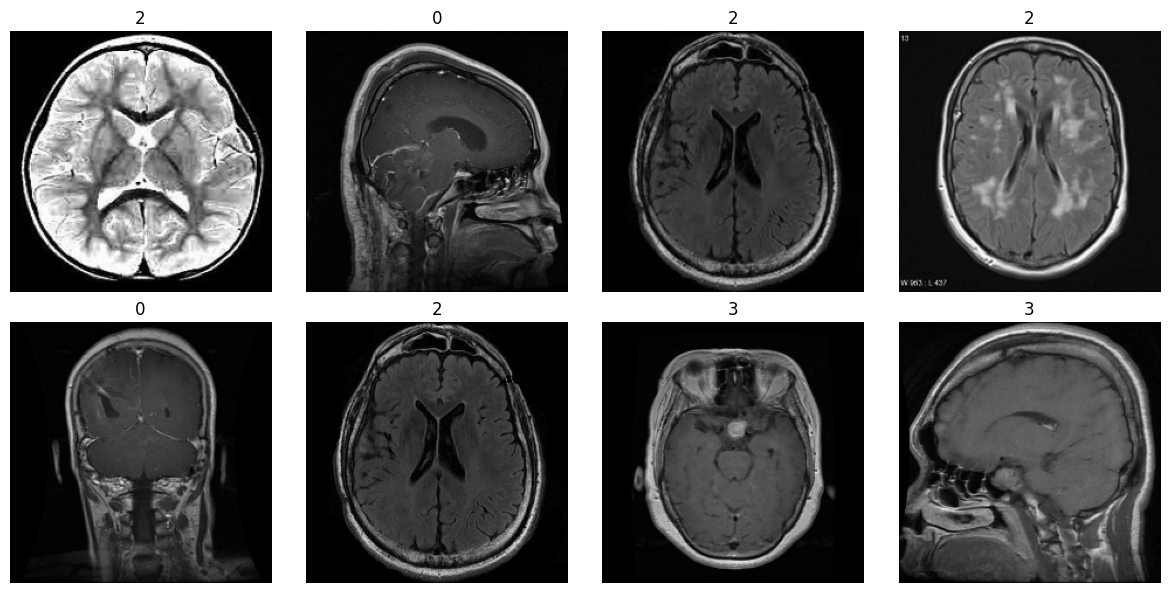

In [15]:
plt.figure(figsize=(12, 6))

for images, labels in train_ds.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
plt.tight_layout()

# Base Convolution Neural Network

In [16]:
from tensorflow.keras import layers, models
import keras

In [39]:
# Build a simple CNN from scratch
model_base = models.Sequential()
model_base.add(layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal',  input_shape=(224,224,3)))
model_base.add(layers.MaxPooling2D((2, 2)))
model_base.add(layers.Conv2D(32, (3, 3), activation='relu'))
model_base.add(layers.MaxPooling2D((2, 2)))
model_base.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_base.add(layers.Flatten())
model_base.add(layers.Dense(2048, activation='relu'))
model_base.add(layers.Dropout(0.4))
model_base.add(layers.Dense(1024, activation='relu'))
model_base.add(layers.Dropout(0.4))
model_base.add(layers.Dense(len(classes), activation='softmax'))

model_base.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 173056)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2048)           │   354,420,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         4,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 356,546,596 (1.33 GB)

 Trainable params: 356,546,596 (1.33 GB)

 Non-trainable params: 0 (0.00 B)

In [40]:
optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001)
model_base.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['sparse_categorical_accuracy'])

In [32]:
# Define the EarlyStopping callback
epochs = 30

early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, monitor="val_loss", restore_best_weights=True)
early_stopping_cb

In [41]:
history_base = model_base.fit(train_ds,
                    epochs=epochs,
                    steps_per_epoch=steps_train,
                    validation_data=val_ds,
                    callbacks=[early_stopping_cb]
                    )

Epoch 1/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 54s 373ms/step - loss: 138.5981 - sparse_categorical_accuracy: 0.4579 - val_loss: 1.0369 - val_sparse_categorical_accuracy: 0.7960
Epoch 2/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 53s 372ms/step - loss: 1.1191 - sparse_categorical_accuracy: 0.7605 - val_loss: 0.4509 - val_sparse_categorical_accuracy: 0.8555
Epoch 3/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 53s 372ms/step - loss: 0.3813 - sparse_categorical_accuracy: 0.8847 - val_loss: 0.3837 - val_sparse_categorical_accuracy: 0.8905
Epoch 4/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 53s 371ms/step - loss: 0.1852 - sparse_categorical_accuracy: 0.9355 - val_loss: 0.3536 - val_sparse_categorical_accuracy: 0.9054
Epoch 5/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 53s 371ms/step - loss: 0.1010 - sparse_categorical_accuracy: 0.9670 - val_loss: 0.3195 - val_sparse_categorical_accuracy: 0.9124
Epoch 6/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 53s 373ms/step - loss: 0.0774 - sparse_categorical_accuracy: 0.9759 - val_loss: 0.3163 - val_sparse_categorical_a

In [42]:
# Plot the training history.
import seaborn as sns
import matplotlib.pyplot as plt

def plot_history(history):
  sns.set(style="ticks", context="talk") # context designed for presentations (larger font etc)
  plt.style.use("dark_background")

  metrics_df = pd.DataFrame(history.history)
  # Plot the training history for 'categorical_accuracy'
  fig, axes= plt.subplots(1, 2, figsize=(10, 6))

  # Plot Accuracy
  sns.lineplot(ax= axes[0], x=metrics_df.index, y=metrics_df['sparse_categorical_accuracy'], label='Training Accuracy', color="#17becf")
  sns.lineplot(ax= axes[0], x=metrics_df.index, y=metrics_df['val_sparse_categorical_accuracy'], label='Validation Accuracy', color="#ff7f0e")
  axes[0].set_title('Training and Validation Accuracy')
  axes[0].set_xlabel('Epoch')
  axes[0].set_ylabel('Accuracy')
  axes[0].set_ylim(0, 1)
  axes[0].legend()

  # Plot Loss
  sns.lineplot(ax= axes[1], x= metrics_df.index, y= metrics_df['loss'], label='Training Loss', color="#17becf")
  sns.lineplot(ax= axes[1], x= metrics_df.index, y= metrics_df['val_loss'], label='Validation Loss', color="#ff7f0e")
  axes[1].set_title('Training and Validation Loss')
  axes[1].set_xlabel('Epoch')
  axes[1].set_ylabel('Loss')
  axes[1].set_ylim(0, axes[1].get_ylim()[1])
  axes[1].legend()

  plt.show()

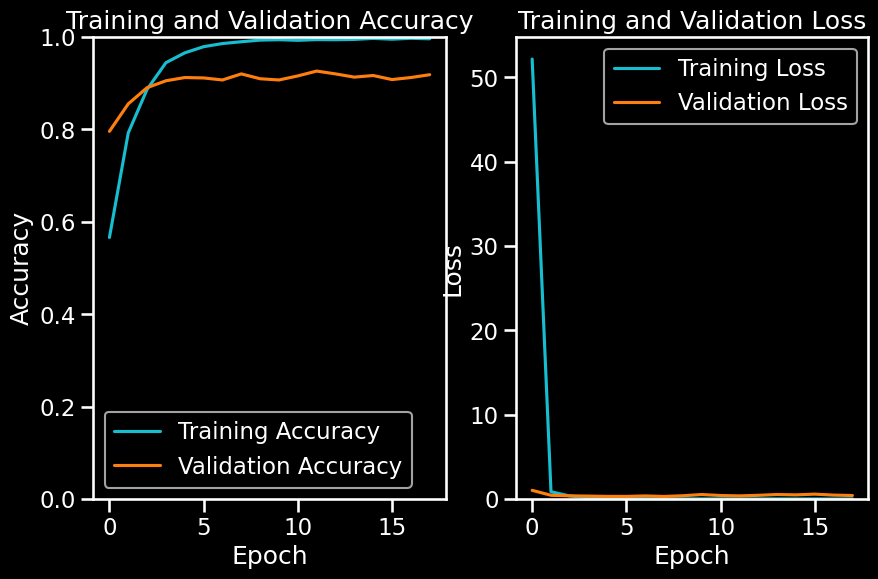

In [43]:
# Extract the metrics from the history object
plot_history(history_base)

In [44]:
y_true, y_pred = eval_model_on_test(model_base)
y_pred_classes = np.argmax(y_pred, axis=1) #get the predicted class label
# np.argmax(y_pred, axis=1): finds the index of the maximum value along axis 1 (which represents the classes)
# converts the probability predictions to the predicted class label

print(confusion_matrix(y_true, y_pred_classes))
print(classification_report(y_true, y_pred_classes))

Found 1311 files belonging to 4 classes.


Predicting on Test Data:   0%|          | 0/11 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Predicting on Test Data:   9%|▉         | 1/11 [00:00<00:02,  4.17it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Predicting on Test Data:  18%|█▊        | 2/11 [00:00<00:01,  4.90it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Predicting on Test Data:  27%|██▋       | 3/11 [00:00<00:01,  5.19it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Predicting on Test Data:  36%|███▋      | 4/11 [00:00<00:01,  5.25it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Predicting on Test Data:  45%|████▌     | 5/11 [00:00<00:01,  5.34it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Predicting on Test Data:  55%|█████▍    | 6/11 [00:01<00:00,  5.46it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Predicting on Test Data:  64%|██████▎   | 7/11 [00:01<00:00,  5.55it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Predicting on Test Data:  73%|███████▎  | 8/11 [00:01<00:00,  5.59it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Predicting on Test Data:  82%|████████▏ | 9/11 [00:01<00:00,  5.60it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Predicting on Test Data:  91%|█████████ | 10/11 [00:01<00:00,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Predicting on Test Data: 100%|██████████| 11/11 [00:01<00:00,  5.61it/s]

[[254  44   1   1]
 [ 14 270  16   6]
 [  4   4 397   0]
 [  0   3   0 297]]
              precision    recall  f1-score   support

           0       0.93      0.85      0.89       300
           1       0.84      0.88      0.86       306
           2       0.96      0.98      0.97       405
           3       0.98      0.99      0.98       300

    accuracy                           0.93      1311
   macro avg       0.93      0.92      0.93      1311
weighted avg       0.93      0.93      0.93      1311



## Transfer learning with Resnet50

In [17]:
model_name = 'resnet50_v01'

# load a new instance of the model.
model_res = tf.keras.applications.resnet50.ResNet50(input_shape=(224,224,3),
                                                include_top=False, # Do not include the ImageNet classifier at the top.
                                                weights='imagenet', # Load weights pre-trained on ImageNet.
                                                )

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [18]:
from tensorflow.keras.models import Model

In [19]:
# points to last layer to ignore the top layer if the object instance include_top was set to True
last_conv_layer = model_res.get_layer('conv5_block3_out')

conv_model = Model(inputs=model_res.input,
                   outputs=last_conv_layer.output)

#Freeze convoutional layers
conv_model.trainable = False

## Train new top

In [20]:
# Start a new Keras Sequential model.
new_model = models.Sequential()

# Add the convolutional part of the model from above.
new_model.add(conv_model)

# the resnet model uses a global average pooling layer before the final dense layer
# other models may just flatten the final convolutional layer or
# use other pooling layers so make sure to check the original model architecture
new_model.add(tf.keras.layers.GlobalAveragePooling2D())

new_model.add(tf.keras.layers.Dense(512, activation='relu'))
new_model.add(tf.keras.layers.Dropout(0.5))  # Dropout to help with overfitting
new_model.add(tf.keras.layers.Dense(256, activation='relu'))
new_model.add(tf.keras.layers.Dropout(0.3))  # Dropout to help with overfitting (originally 0.3)
new_model.add(tf.keras.layers.Dense(len(classes), activation='softmax'))

In [21]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
optimizer.learning_rate.numpy()

np.float32(1e-04)

In [22]:
new_model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['sparse_categorical_accuracy'])

In [23]:
new_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional (Functional)         │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,769,156 (94.49 MB)

 Trainable params: 1,181,444 (4.51 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [24]:
initial_epochs = 10

In [25]:
history = new_model.fit(train_ds,
                        epochs=initial_epochs,
                        steps_per_epoch=steps_train,
                        validation_data=val_ds
                        )

Epoch 1/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 42s 268ms/step - loss: 1.2750 - sparse_categorical_accuracy: 0.5040 - val_loss: 0.3755 - val_sparse_categorical_accuracy: 0.8800
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 37s 259ms/step - loss: 0.4863 - sparse_categorical_accuracy: 0.8158 - val_loss: 0.2863 - val_sparse_categorical_accuracy: 0.8967
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 37s 260ms/step - loss: 0.3860 - sparse_categorical_accuracy: 0.8541 - val_loss: 0.2506 - val_sparse_categorical_accuracy: 0.9159
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 38s 265ms/step - loss: 0.3048 - sparse_categorical_accuracy: 0.8841 - val_loss: 0.2316 - val_sparse_categorical_accuracy: 0.9151
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 37s 262ms/step - loss: 0.2679 - sparse_categorical_accuracy: 0.9006 - val_loss: 0.2081 - val_sparse_categorical_accuracy: 0.9282
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 37s 261ms/step - loss: 0.2574 - sparse_categorical_accuracy: 0.9044 - val_loss: 0.1964 - val_sparse_categorical_acc

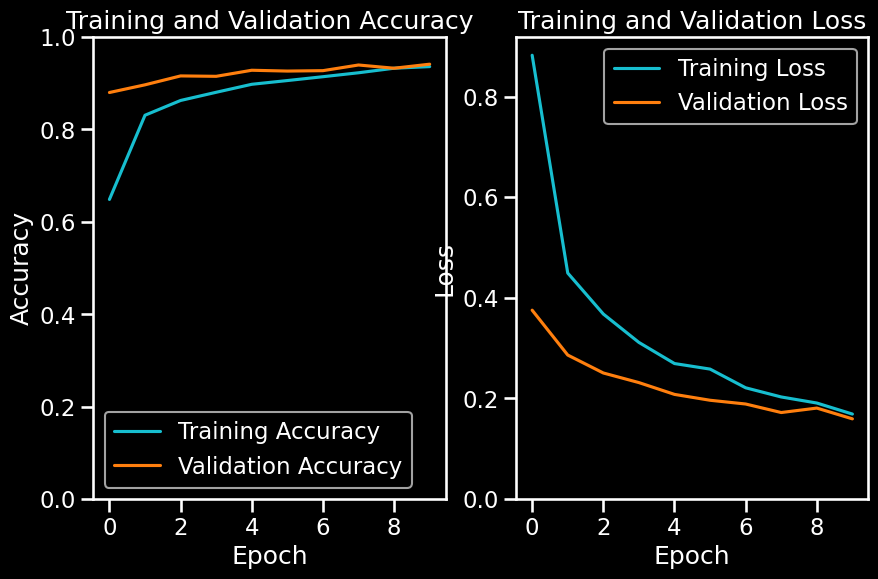

In [45]:
# Extract the metrics from the history object
plot_history(history)

In [29]:
y_true, y_pred = eval_model_on_test(new_model)
y_pred_classes = np.argmax(y_pred, axis=1) #get the predicted class label
# np.argmax(y_pred, axis=1): finds the index of the maximum value along axis 1 (which represents the classes)
# converts the probability predictions to the predicted class label

print(confusion_matrix(y_true, y_pred_classes))
print(classification_report(y_true, y_pred_classes))

Found 1311 files belonging to 4 classes.


Predicting on Test Data:   0%|          | 0/11 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 208ms/step


Predicting on Test Data:   9%|▉         | 1/11 [00:02<00:20,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step


Predicting on Test Data:  18%|█▊        | 2/11 [00:02<00:12,  1.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step


Predicting on Test Data:  27%|██▋       | 3/11 [00:03<00:09,  1.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step


Predicting on Test Data:  36%|███▋      | 4/11 [00:04<00:07,  1.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step


Predicting on Test Data:  45%|████▌     | 5/11 [00:05<00:05,  1.03it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step


Predicting on Test Data:  55%|█████▍    | 6/11 [00:06<00:04,  1.07it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step


Predicting on Test Data:  64%|██████▎   | 7/11 [00:07<00:03,  1.09it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step


Predicting on Test Data:  73%|███████▎  | 8/11 [00:08<00:02,  1.10it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step


Predicting on Test Data:  82%|████████▏ | 9/11 [00:09<00:01,  1.12it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step


Predicting on Test Data:  91%|█████████ | 10/11 [00:09<00:00,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Predicting on Test Data: 100%|██████████| 11/11 [00:11<00:00,  1.00s/it]

[[254  45   0   1]
 [ 14 262  19  11]
 [  0   5 400   0]
 [  1   6   0 293]]
              precision    recall  f1-score   support

           0       0.94      0.85      0.89       300
           1       0.82      0.86      0.84       306
           2       0.95      0.99      0.97       405
           3       0.96      0.98      0.97       300

    accuracy                           0.92      1311
   macro avg       0.92      0.92      0.92      1311
weighted avg       0.92      0.92      0.92      1311



# Unfreeze conv5 then conv4 for fine tuning

In [30]:
conv_model.trainable = True

In [33]:
# Unfreeze conv5 block first
for layer in conv_model.layers:
  if 'conv5' not in layer.name:
    layer.trainable = False
  if 'bn' in layer.name:  # Keep BatchNormalization layers frozen
    layer.trainable = False

optimizer_fine_tuning = tf.keras.optimizers.Adam(learning_rate=1e-4)  # Slightly higher learning rate for initial fine-tuning
new_model.compile(optimizer=optimizer_fine_tuning, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['sparse_categorical_accuracy'])
history_fine_tuning = new_model.fit(train_ds,
                    epochs=3, # Fine-tune for a few epochs
                    steps_per_epoch=steps_train,
                    validation_data=val_ds,
                    callbacks = [early_stopping_cb]
                    )


Epoch 1/3
143/143 ━━━━━━━━━━━━━━━━━━━━ 51s 326ms/step - loss: 0.3891 - sparse_categorical_accuracy: 0.8622 - val_loss: 0.1706 - val_sparse_categorical_accuracy: 0.9291
Epoch 2/3
143/143 ━━━━━━━━━━━━━━━━━━━━ 45s 316ms/step - loss: 0.1421 - sparse_categorical_accuracy: 0.9470 - val_loss: 0.1399 - val_sparse_categorical_accuracy: 0.9457
Epoch 3/3
143/143 ━━━━━━━━━━━━━━━━━━━━ 45s 315ms/step - loss: 0.0914 - sparse_categorical_accuracy: 0.9679 - val_loss: 0.1224 - val_sparse_categorical_accuracy: 0.9580


In [34]:
# Unfreeze conv4 block after fine-tuning conv5
for layer in conv_model.layers:
  if not ('conv4' in layer.name or 'conv5' in layer.name):
    layer.trainable = False
  if 'bn' in layer.name:  # Keep BatchNormalization layers frozen
    layer.trainable = False

optimizer_fine_tuning = tf.keras.optimizers.Adam(learning_rate=1e-5)  # Lower learning rate for further fine-tuning
new_model.compile(optimizer=optimizer_fine_tuning, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['sparse_categorical_accuracy'])
history_fine_tuning = new_model.fit(train_ds,
                    epochs=50, # Fine-tune for more epochs
                    steps_per_epoch=steps_train,
                    validation_data=val_ds,
                    callbacks = [early_stopping_cb]
                    )

Epoch 1/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 51s 326ms/step - loss: 0.0366 - sparse_categorical_accuracy: 0.9871 - val_loss: 0.1055 - val_sparse_categorical_accuracy: 0.9676
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 48s 336ms/step - loss: 0.0108 - sparse_categorical_accuracy: 0.9972 - val_loss: 0.1184 - val_sparse_categorical_accuracy: 0.9685
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 45s 316ms/step - loss: 0.0065 - sparse_categorical_accuracy: 0.9974 - val_loss: 0.1347 - val_sparse_categorical_accuracy: 0.9685
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 45s 316ms/step - loss: 0.0027 - sparse_categorical_accuracy: 0.9994 - val_loss: 0.1562 - val_sparse_categorical_accuracy: 0.9702
Epoch 5/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 45s 315ms/step - loss: 0.0020 - sparse_categorical_accuracy: 0.9994 - val_loss: 0.1653 - val_sparse_categorical_accuracy: 0.9702
Epoch 6/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 45s 315ms/step - loss: 6.3208e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.1883 - val_sparse_categorical

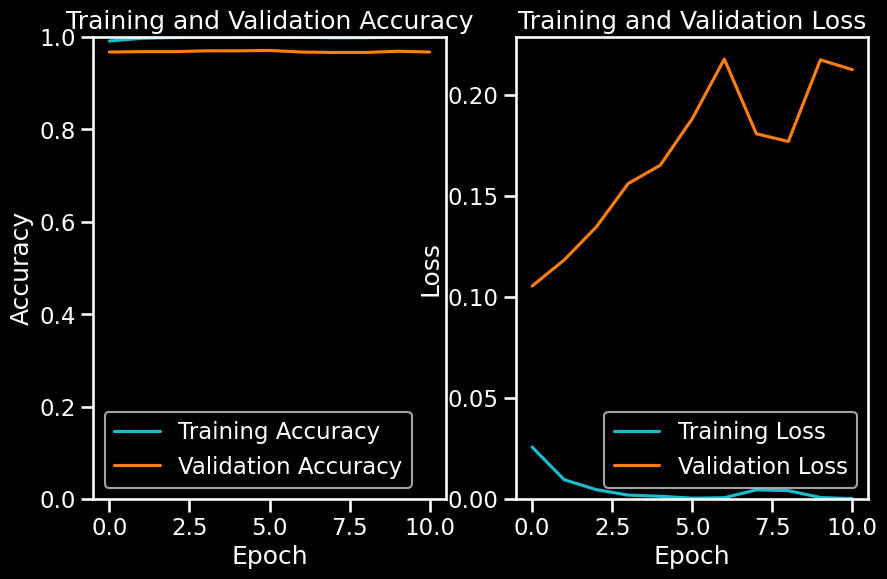

In [46]:
# Extract the metrics from the history object
plot_history(history_fine_tuning)

In [38]:
y_true, y_pred = eval_model_on_test(new_model)
y_pred_classes = np.argmax(y_pred, axis=1) #get the predicted class label
# np.argmax(y_pred, axis=1): finds the index of the maximum value along axis 1 (which represents the classes)
# converts the probability predictions to the predicted class label

print(confusion_matrix(y_true, y_pred_classes))
print(classification_report(y_true, y_pred_classes))

Found 1311 files belonging to 4 classes.


Predicting on Test Data:   0%|          | 0/11 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 223ms/step


Predicting on Test Data:   9%|▉         | 1/11 [00:01<00:18,  1.87s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 214ms/step


Predicting on Test Data:  18%|█▊        | 2/11 [00:02<00:11,  1.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step


Predicting on Test Data:  27%|██▋       | 3/11 [00:03<00:08,  1.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step


Predicting on Test Data:  36%|███▋      | 4/11 [00:04<00:07,  1.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step


Predicting on Test Data:  45%|████▌     | 5/11 [00:05<00:05,  1.04it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step


Predicting on Test Data:  55%|█████▍    | 6/11 [00:06<00:04,  1.07it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step


Predicting on Test Data:  64%|██████▎   | 7/11 [00:07<00:03,  1.09it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step


Predicting on Test Data:  73%|███████▎  | 8/11 [00:08<00:02,  1.11it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step


Predicting on Test Data:  82%|████████▏ | 9/11 [00:08<00:01,  1.12it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step


Predicting on Test Data:  91%|█████████ | 10/11 [00:09<00:00,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Predicting on Test Data: 100%|██████████| 11/11 [00:11<00:00,  1.02s/it]

[[290   9   0   1]
 [  4 290   6   6]
 [  0   2 403   0]
 [  1   1   0 298]]
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       300
           1       0.96      0.95      0.95       306
           2       0.99      1.00      0.99       405
           3       0.98      0.99      0.99       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311

